# Publicis Sapient Project - Named Entity Recognition

## <font color=brown>Baseline-Model</font>

# Introduction
<p><b>What is NER?</b><br>
    NER, or Named Entity Recognition, is a component of Natural Language Processing (NLP) that focuses on identifying and categorizing named entities within a given text.
</p>
<p><b>What it does?</b><br>
NER locates and classifies named entities in text, such as people, places, organizations, time expressions, and quantities.
</p>
<p>
    <b>How it works?</b><br>
    Named Entity Recognition (NER) detects specific words or phrases within a document and subsequently categorizes them into established classifications.
</p>
<p>
    <b>Why it's useful?</b><br>
    Named Entity Recognition (NER) enhances document translation by offering contextual insights that aid in comprehending sentences. For instance, in the sentence "Apple released a new iPhone today," NER can recognize "Apple" as an organization.
</p>

<p><b>Notebook Strategy</b><br>
    In this notebook, we will utilize <font style='color:brown'><b>BertForTokenClassification</b></font>, a model provided by the <font color=blue>Transformers </font>library from HuggingFace.
    This model
    is built on the <font color=blue>BERT architecture</font> and features a token <font color=blue>classification head</font>, enabling it to perform predictions at the <font color=blue>token level</font>
    instead of the sequence level. Named entity recognition is generally approached as a token classification task, which is the purpose of
    our implementation
</p>
<p>This notebook explores the concept of <font color=blue><b>transfer learning</b></font>, which involves initially pretraining a large neural network in an unsupervised manner, followed by <font color=blue>fine-tuning</blue></font> the network for a specific task. In this instance, BERT serves as the pretrained neural network, having been trained on two tasks: masked language modeling and next sentence prediction.</p>
<p><b>Fine-tuning</b> involves supervised learning, which indicates that a <b>labeled dataset</b> is required.</p>
<p>
    <b>Note:</b>
    <br>
    <ol>
        <li>
            This notebook presupposes that the reader possesses a fundamental understanding of several key concepts and technologies that are essential for effectively engaging with the content presented herein. Specifically, it assumes familiarity with deep learning, which is a subset of machine learning that focuses on algorithms inspired by the structure and function of the brain, particularly artificial neural networks.
        </li>
        <li>
        Additionally, the reader should have a working knowledge of BERT (Bidirectional Encoder Representations from Transformers), a state-of-the-art natural language processing model developed by Google. BERT is designed to understand the context of words in a sentence by considering the words that come before and after them, making it particularly effective for tasks such as text classification, question answering, and language inference.
    </li>
        <li>
            Furthermore, proficiency in the PyTorch framework is also assumed. PyTorch is an open-source machine learning library widely used for applications in deep learning and artificial intelligence. It provides a flexible and dynamic computational graph, which allows for easy experimentation and debugging, making it a popular choice among researchers and practitioners in the field.
        </li>
    </ol>
    In summary, this notebook is intended for individuals who are already well-versed in these foundational topics, as it will build upon this knowledge to explore more advanced concepts and applications related to deep learning, BERT, and the use of PyTorch for implementing various models and techniques.
</p>

<p>
    <b>Notebook Sections</b><br>
    This notebook is divided into following sections:
    <ul>
        <li>A. Setting Environment</li>
        <li>B. Set the Device (cpu or mps)</li>
        <li>C. Reading Dataset</li>
        <li>D. PreProcessing Dataset</li>
        <li>E. Setting Tokenizer</li>
        <li>F. Seen Dataset</li>
        <li>G. Preparing the Input Data</li>
        <li>H. Create the Model, Optimizer and Scheduler</li>
        <li>I. Model Training</li>
        <li>J. Evaluation</li>
        <li>K. Testing Trained Model</li>
        <li>L. Helper Function</li>
        <li>M. Inference</li>
        <li>N. Saving and Loading Utilities for Model</li>   
    </ul>
</p>

## A. Setting up the environment and importing Python libraries
<p>
    This notebook assumes that you have the following libraries installed:
    <ul>
        <li>pandas</li>
        <li>numpy</li>
        <li>sklearn</li>
        <li>pytorch</li>
        <li>transformers</li>
        <li>matplotlib</li>
        <li>seaborn</li>
    </ul>

Note: Please ensure that you have all the libraries installed.

It is recommended to use the cpu device in case mac osx mps (Gpus) are not available.
</p>

In [136]:
# Uncomment to install libraries
# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install torch
# !pip install transformers
# !pip install matplotlib
# !pip install seaborn

# Note: For zsh shell remove exclamation (!) mark

In [9]:
import collections
from itertools import chain
import random

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, random_split
from torch.optim import AdamW

from transformers import BertTokenizer
from transformers import BertForTokenClassification
from transformers import get_linear_schedule_with_warmup

import matplotlib.pyplot as plt
import seaborn as sns

## B. Set Device - Check if MPS (Metal Performance Shaders) is available
<p>
    PyTorch uses the new Metal Performance Shaders (MPS) backend for GPU training acceleration. This MPS backend extends the PyTorch
    framework, providing scripts and capabilities to set up and run operations on Mac.
</p>

In [10]:
def get_device(force_cpu_device=False):
    # default device
    device = torch.device('cpu')
    # Check that MPS  is available
    if not torch.backends.mps.is_available():
        if not torch.backends.mps.is_built():
            print("MPS not available because the current PyTorch install was not "
                  "built with MPS enabled.")
        else:
            print("MPS not available because the current MacOS version is not 12.3+ "
                  "and/or you do not have an MPS-enabled device on this machine.")

    else:
        mps_device = torch.device("mps")
        device = mps_device
        print("mps device found")
    # Force to use the cpu device
    if force_cpu_device:
        print("force to use cpu")
        device = torch.device('cpu')
    return device

In [11]:
device = get_device()
print(f"device to be used: {device}")

mps device found
device to be used: mps


## C. Reading Dataset

In [13]:
# setting the filepath
file_path = "/Users/akg/jupyter/company_interview/sapient/data/ner_dataset.csv"

# read the raw data
raw_df = pd.read_csv(file_path, engine='python', sep=',', encoding='latin1')

#### Peek into raw data

In [14]:
raw_df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


## D. Preprocessing Data

### 1. Check if there are any NaN values in Word and Tag Columns

#### 1.1. Tag columns

In [18]:
tag_null_mask = raw_df[['Tag']].isnull().any(axis=1)
tag_null_rows = raw_df[tag_null_mask]

In [19]:
print(f"number of rows where tag is NaN: {tag_null_rows.size}")

number of rows where tag is NaN: 0


#### 1.2. Word columns

In [20]:
word_null_mask = raw_df[['Word']].isnull().any(axis=1)
word_null_rows = raw_df[word_null_mask]

In [21]:
print(f"number of rows where word is NaN: {word_null_rows.size}")

number of rows where word is NaN: 40


##### 1.2. a) Let us have a look at the sentences where word is null

In [22]:
word_null_index = word_null_rows.index.to_list()

##### 1.2. b) First sentence where Word have NaN Value

In [23]:
# Lets look at the first sentence with NaN value
raw_df.loc[word_null_index[0]:word_null_index[0]+5]

,Sentence #,Word,POS,Tag
197658,Sentence: 9047,NaN,NN,O
197659,NaN,of,IN,O
197660,NaN,the,DT,O
197661,NaN,32,CD,O
197662,NaN,freed,VBN,O
197663,NaN,Saturday,NNP,B-tim


Here we can see that <b>NaN</b> words could be <b>None</b> so the sentence - "None of the 32 freed ..." makes more sense
rather than 'NaN of the 32 freed'

##### 1.2. c) Second sentence where Word have NaN Value

In [25]:
# Lets look at the second sentence with NaN value
raw_df.loc[word_null_index[1]:word_null_index[1]+5]

,Sentence #,Word,POS,Tag
256026,Sentence: 11709,NaN,NN,O
256027,NaN,of,IN,O
256028,NaN,the,DT,O
256029,NaN,injuries,NNS,O
256030,NaN,was,VBD,O
256031,NaN,serious,JJ,O


Here also, we can see that <b>NaN</b> words could be <b>None</b> so the sentence - 'None of the injuries ..." makes more sense
rather than 'NaN of the injuries ...'

#### Conclusion
We can safely replace the <b>NaN</b> with <b>None</b> so that the corresponding sentences makes more sense.

### 2. Replace NaN with None

In [26]:
# Replace the word
raw_df.Word = raw_df.Word.fillna('None')

#### 2.1. Check if the values are replaced successfully

In [27]:
word_null_mask = raw_df[['Word']].isnull().any(axis=1)
word_null_rows = raw_df[word_null_mask]

In [28]:
print(f"number of rows where word is NaN: {word_null_rows.size}")

number of rows where word is NaN: 0


#### 2.2. Let us check if values are indeed replaced

In [22]:
raw_df.iloc[word_null_index]

,Sentence #,Word,POS,Tag
197658,Sentence: 9047,None,NN,O
256026,Sentence: 11709,None,NN,O
257069,Sentence: 11759,None,NN,O
571211,Sentence: 26129,None,NN,O
613777,Sentence: 28049,None,NN,O
747019,Sentence: 34152,None,NN,O
901758,Sentence: 41181,None,NN,O
903054,Sentence: 41244,None,NN,O
944880,Sentence: 43177,None,NN,O
1003438,Sentence: 45887,None,NN,O


#### 3) Convert Word column to lower case (Imp)
```
Bert-base-uncased transforms word to [unk] token if it starts with Capital Word.
```

In [23]:
#raw_df.Word = raw_df.Word.str.lower()

In [24]:
#raw_df[['Word']].head(5)

,Word
0,thousands
1,of
2,demonstrators
3,have
4,marched


#### 2.3. Get list of indices where each sentence begins

In [29]:
# compute the row indices indicating the begining of each sentence
sent_index_col = 'Sentence #'
sent_idx = raw_df[raw_df[sent_index_col].notnull()].index.tolist()

In [31]:
# total number of sentences
print(f"Total number of sentences: {len(sent_idx)}")

Total number of sentences: 47959


#### 2.4. Compute list of sentences and corresponding list of labels

In [32]:
# column name information
tag_col = 'Tag'
word_col = 'Word'

# list of words forming the sentences
all_sentences = []

# list of corresponding labels for each tokens
all_labels = []

# do for each sentence and labels
for i in range(len(sent_idx)-1):
    all_sentences.append(raw_df.loc[sent_idx[i]:sent_idx[i+1]-1,word_col].tolist())
    all_labels.append(raw_df.loc[sent_idx[i]:sent_idx[i+1]-1,tag_col].tolist())

# append the last sentence as well
all_sentences.append(raw_df.loc[sent_idx[-1]:,word_col].tolist())
all_labels.append(raw_df.loc[sent_idx[-1]:,tag_col].tolist())

In [33]:
print(f"total number of sentences = {len(all_sentences)}")
print(f"total number of labels = {len(all_labels)}")

total number of sentences = 47959
total number of labels = 47959


#### 2.5 Compute frequence of each tag

In [34]:
unique_tags = raw_df.Tag.value_counts()
unique_tags

Tag
O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: count, dtype: int64

### 3. Remove the sentences that doesn't contain our targeted entities

##### Helper functions

In [35]:
# Helper Functions

# Function to check if all values in the list are same
# and equal to 'val'
def check_all(L, val):
    """
    Function to check if all values in a list L are
    equal to 'val'
    """
    return all(x == val and x is not True for x in L)

# Function to remove list of indices from a List
def del_list_indexes(l, id_to_del):
    """
    Function to remove list of indices from a list
    """
    somelist = [i for j, i in enumerate(l) if j not in id_to_del]
    return somelist

#### 3.1. Remove the sentences that contain only "O" tags and don't contain any other target labels

In [36]:
# This is to remove the sentences that doesn't contain our targeted entities.
idx_to_remove = []
for index, labels_ in enumerate(all_labels):
    if check_all(labels_, "O"):
        idx_to_remove.append(index)

# Total number of sentences which contains all "O" labels
print(f"number of sentences which contains all 'O' labels: {len(idx_to_remove)}")

number of sentences which contains all 'O' labels: 7042


In [37]:
# check Sample Index
print(f"Few sample indices are: {idx_to_remove[:4]}")

# check any computed index if it contains all "O"
print(f"sample sentence: {all_sentences[idx_to_remove[0]]}")
print(f"sample labels: {all_labels[idx_to_remove[0]]}")

Few sample indices are: [3, 10, 36, 38]
sample sentence: ['Police', 'put', 'the', 'number', 'of', 'marchers', 'at', '10,000', 'while', 'organizers', 'claimed', 'it', 'was', '1,00,000', '.']
sample labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


#### 3.2. Update the sentences and labels list after deleting the indices for all "O" sentences

In [38]:
# remove indices to be deleted get new label list 
all_labels_ = del_list_indexes(all_labels, idx_to_remove)

# remove indices to be deleted get new sentence list 
all_sentences_ = del_list_indexes(all_sentences, idx_to_remove)

# Inormation for updated sentences
print("Total number of sentences after removing unwanted sentences containing all 'O' labels")
print(f"(updated) total number of sentences = {len(all_sentences_)}")
print(f"(updated) total number of labels = {len(all_labels_)}")

Total number of sentences after removing unwanted sentences containing all 'O' labels
(updated) total number of sentences = 40917
(updated) total number of labels = 40917


#### 3.3. Compute new frequency of tags

In [39]:
# Flattent the nested list
flatten_list = np.concatenate(all_labels_).ravel().tolist()

# Compute the updated frequency of each tags
counter = collections.Counter(flatten_list)

# display the frequencies
counter

Counter({'O': 770252,
         'B-geo': 37644,
         'B-tim': 20333,
         'B-org': 20143,
         'I-per': 17251,
         'B-per': 16990,
         'I-org': 16784,
         'B-gpe': 15870,
         'I-geo': 7414,
         'I-tim': 6528,
         'B-art': 402,
         'B-eve': 308,
         'I-art': 297,
         'I-eve': 253,
         'B-nat': 201,
         'I-gpe': 198,
         'I-nat': 51})

#### 3.4. Peek into example sentences

In [40]:
# check if the sentences are properly collected with their labels
# first sentence
example_sentence_first = all_sentences[0]
example_label_first = all_labels[0]

# last sentence
example_sentence_last = all_sentences[-1]
example_label_last = all_labels[-1]

# print information of sentences along with labels
# ================================================
print("First Sentence")
print("---------------")
print(f"text: {' '.join(example_sentence_first)}\n")
print(f"tokens: {example_sentence_first}\n")
print(f"labels: {example_label_first}\n")

print("Last Sentence")
print("---------------")
print(f"text: {' '.join(example_sentence_last)}\n")
print(f"tokens: {example_sentence_last}\n")
print(f"labels: {example_label_last}")

First Sentence
---------------
text: Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .

tokens: ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']

labels: ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']

Last Sentence
---------------
text: Indian forces said they responded to the attack

tokens: ['Indian', 'forces', 'said', 'they', 'responded', 'to', 'the', 'attack']

labels: ['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


### 4. Splitting Data - Seen and Unseen/Held-out-data/Test Data


<b>All Data</b> - Will be split into <b>seen</b>(80%) and <b>unseen/test</b> data (20%)

1. <b>Seen Dataset</b> - Think of it as the data which the model see's to get the final model which is ready to be used.
It is used to train and validate the model hence it will be further splitted into:
- training dataset(90%) and validation dataset(10%)

2. <b>Test Data</b> - It is unseen data a.k.a Test data or held-out-data. It is used for testing the final trained model

<p>
So eventually we will have the following datasets:
    
1. training data
2. validation data
3. test data (unseen)
</p>

#### 4.1. Split the Data into 'seen data' and 'test (unseen) data'
- "All data" = Seen data + Unseen/Test data

In [42]:
# split the all data into seen and test data (unseen data)
seen_sentences, test_sentences, seen_labels, test_labels = train_test_split(
    all_sentences_, all_labels_, test_size=0.2, random_state=50, shuffle=True)

#### 4.2. Number of sentences in seen and test data

In [43]:
print("Seen Data information (the data which will further be slitted into train and validation dataset):")
print("---------------------")
print(f"total number of sentences in seen data: {len(seen_sentences)}")
print(f"total number of sequence of labels in seen data: {len(seen_labels)}\n")

print("Test Data (or Unseen data) information:")
print("---------------------------------------")
print(f"total number of sentences in test data: {len(test_sentences)}")
print(f"total number of sequence of labels in test data: {len(test_labels)}\n")

Seen Data information (the data which will further be slitted into train and validation dataset):
---------------------
total number of sentences in seen data: 32733
total number of sequence of labels in seen data: 32733

Test Data (or Unseen data) information:
---------------------------------------
total number of sentences in test data: 8184
total number of sequence of labels in test data: 8184



## E. Tokenizer
```
We will use BERT Tokenizer to tokenize the sentences.
- Preparing input text data for Feeding it into BERT model by converting and spilting the text into tokens and mapping the tokens using BertTokenizer functon
```

In [56]:
# tokenizer from Bert uncased
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

####  Setting Tokenizer Parameters

In [44]:
# Note: Here max len is the number of words of sentence we will consider
MAX_LEN = 125 # max length of sentence (before padding)

# This is max seq len
MAX_PAD_LEN = 128 # max length of (tokenized + padded tokens)

## F. Dealing with 'Seen' Dataset
This is the data that we will use to build the <b>final model</b> ready to be deployed in <b>production</b> environment

### 1. Computing Label2Idx and Idx2Label Map

#### 1.1. Computing Unique Labels

In [49]:
# compute the unique labels from the seen data
unique_labels = set(chain(*seen_labels))

print(f"total number of unique labels: {len(unique_labels)}")

total number of unique labels: 17


#### 1.2. Mapping labels to integers - label2idx

In [50]:
# Mapping labels to integers
# ---------------------------

# Map that store label-id pairs
label2idx = {}

# For each label, compute the index
for (i, label) in enumerate(unique_labels):
    # Map it to its integer
    label2idx[label] = i

##### 1.2. a) Peek into label to index mapping

In [51]:
print(label2idx)

{'I-art': 0, 'I-eve': 1, 'B-art': 2, 'B-eve': 3, 'I-org': 4, 'I-tim': 5, 'I-gpe': 6, 'B-per': 7, 'B-org': 8, 'O': 9, 'B-geo': 10, 'I-per': 11, 'I-geo': 12, 'B-tim': 13, 'B-nat': 14, 'I-nat': 15, 'B-gpe': 16}


#### 1.3. Mapping integers to labels - idx2label

In [52]:
idx2label = {v:k for k,v in label2idx.items()}

##### 1.3. a) Peek into index to label mapping

In [53]:
print(idx2label)

{0: 'I-art', 1: 'I-eve', 2: 'B-art', 3: 'B-eve', 4: 'I-org', 5: 'I-tim', 6: 'I-gpe', 7: 'B-per', 8: 'B-org', 9: 'O', 10: 'B-geo', 11: 'I-per', 12: 'I-geo', 13: 'B-tim', 14: 'B-nat', 15: 'I-nat', 16: 'B-gpe'}


### 2. Computing the length of each sentence

In [57]:
# list containing length of each sentence
# Note: Here we have added truncation = true becuase some of the sentences
# have max length > 512 so we will truncate them
length_of_sentences = [len(tokenizer.encode(' '.join(i), add_special_tokens=True, truncation=True)) for i in seen_sentences]

#### 2.1. Min, Max and Median length of sentences

In [58]:
max_sent_len = max(length_of_sentences)
min_sent_len = min(length_of_sentences)
median_sent_len = int(np.median(length_of_sentences))

print(f"Minimum Sentence length: {min_sent_len}") 
print(f"Maximum Sentence length: {max_sent_len}") 
print(f"Median Sentence length: {median_sent_len}") 

Minimum Sentence length: 4
Maximum Sentence length: 154
Median Sentence length: 27


#### 2.3 Histograms of lengths

<Figure size 2400x2400 with 0 Axes>

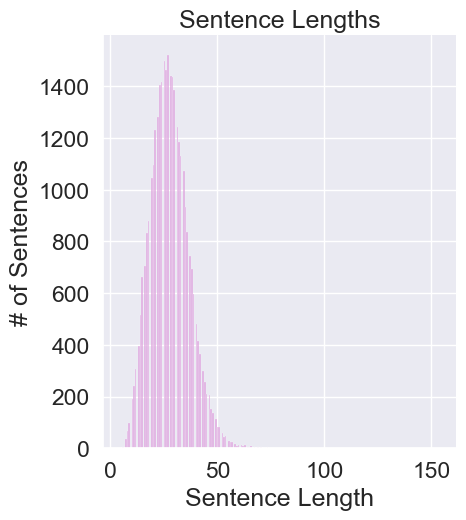

In [59]:
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.figure(figsize=(24,24))
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of comment lengths.
sns.displot(length_of_sentences, kde=False, rug=False,color='plum')

plt.title('Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('# of Sentences')
plt.show()

### 3. Lets check the encoding of bert tokenizer on a sample sentence

In [61]:
sample_sentence = seen_sentences[1]
print(f"sample sentence:\n{sample_sentence}\n")
print(f"num of words in sample sentence: {len(sample_sentence)}")

sample sentence:
['A', 'huge', 'slick', 'of', 'toxic', 'chemicals', 'has', 'entered', 'Russian', 'territory', 'from', 'China', 'after', 'flowing', 'downstream', 'from', 'a', 'chemical-plant', 'explosion', 'last', 'month', '.']

num of words in sample sentence: 22


#### 3.1. Encoding a sample sentence

In [62]:
# compute the encodings on the sample sentence
# i.e convert the tokens to integer ids as per the Bert Tokenizer
sample_tokens = tokenizer.tokenize(' '.join(sample_sentence))
print(f"sample tokens:\n{sample_tokens}")
print(f"num of tokens: {len(sample_tokens)}\n")

# This will add special [CLS] at the begining and [SEP] token at the end of sentence.
sample_encodings = tokenizer.encode(' '.join(sample_sentence))

# We can check the new tokens with special tokens included
print(f"sample encodings are:\n{sample_encodings}")
print(f"num of integer id tokens: {len(sample_encodings)}\n")

# number of aditional tokens
print(f"Hence, num of additional tokens included are: {len(sample_encodings) - len(sample_tokens)}")

sample tokens:
['a', 'huge', 'slick', 'of', 'toxic', 'chemicals', 'has', 'entered', 'russian', 'territory', 'from', 'china', 'after', 'flowing', 'downstream', 'from', 'a', 'chemical', '-', 'plant', 'explosion', 'last', 'month', '.']
num of tokens: 24

sample encodings are:
[101, 1037, 4121, 13554, 1997, 11704, 12141, 2038, 3133, 2845, 3700, 2013, 2859, 2044, 8577, 13248, 2013, 1037, 5072, 1011, 3269, 7738, 2197, 3204, 1012, 102]
num of integer id tokens: 26

Hence, num of additional tokens included are: 2


#### 3.2 Decoding the encoded sample

In [63]:
# Here, decoding means coverting the intger ids back to string
sample_decodings = tokenizer.decode(sample_encodings)
# check if special tokens [cls] and [sep] are indeed added
print(f"sample decodings:\n{sample_decodings}","\n")
print(f"the decoded sample have following tokens:\n{sample_decodings.split(" ")}\n")
print(f"num of tokens in decoded sentence: {len(sample_decodings.split(" "))}")

sample decodings:
[CLS] a huge slick of toxic chemicals has entered russian territory from china after flowing downstream from a chemical - plant explosion last month. [SEP] 

the decoded sample have following tokens:
['[CLS]', 'a', 'huge', 'slick', 'of', 'toxic', 'chemicals', 'has', 'entered', 'russian', 'territory', 'from', 'china', 'after', 'flowing', 'downstream', 'from', 'a', 'chemical', '-', 'plant', 'explosion', 'last', 'month.', '[SEP]']

num of tokens in decoded sentence: 25


## G. Preparing the Input to be fed into BERT Model 

We need to compute the following:
1. Input ids
2. Attention Masks
3. Padded Token Labels

### 1. Computing Input Ids and Attention Masks

In [64]:
def get_input_ids_and_attention_masks(sentences, tokenizer, max_length=MAX_PAD_LEN):
    """
    Function to compute Input Ids and Attention Masks.
    It tokenize all of the sentences and map the tokens to thier word IDs.
    """
    # stores the input ids for each sentence
    input_ids = []
    # stores the attention mask for each sentence
    attention_masks = []

    # For every sentence, find the input ids and attention masks
    # as torch tensor
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            ' '.join(sent),     # Sentence to encode.
                            add_special_tokens = True,     # Add '[CLS]' and '[SEP]'
                            truncation=True,
                            max_length = MAX_PAD_LEN,     # Pad & truncate all sentences.
                            padding='max_length',
                            return_attention_mask = True,     # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )
        # Add the input ids
        input_ids.append(encoded_dict['input_ids'][0])
    
        # And the attention mask
        attention_masks.append(encoded_dict['attention_mask'][0])
        
    return input_ids, attention_masks

In [65]:
# compute the input ids, attention mask for each sentence in seen data
input_ids, attention_masks = get_input_ids_and_attention_masks(sentences=seen_sentences,
                                                                 tokenizer=tokenizer,
                                                                 max_length=MAX_PAD_LEN)

#### 1.1 Lets check the input ids, attention masks for a sentence in seen data

In [66]:
# lets check for the sentence with index 2
print('Original: ', seen_sentences[2])
print('Token IDs:', input_ids[2])
print('Masks:', attention_masks[2])

Original:  ['The', 'witnesses', 'say', 'Ethiopian', 'troops', 'opened', 'fire', 'after', 'the', 'blast', '.']
Token IDs: tensor([  101,  1996,  9390,  2360, 15101,  3629,  2441,  2543,  2044,  1996,
         8479,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,

### 2. Computing labels for BERT tokens
<p>
<font color=brown>Bert Tokenizer</font> adds additional <b>subwords</b> during its tokenization process hence it is
very important to ensure that the final tokens from BERT Tokenizer are <b>mapped</b> to <b>correct
labels.</b>

To achieve the same we will use two functions:

<b>1. tokenize_and_preserve labels:</b> - This will do the tokenization at the word level for each sentence and then map the
correct label for the word to each of its subwords or tokens.

<b>2. match_tokens_labels</b> - This function will help to compute the new padded labels (of max pad len) in which each of the
token is mapped to correct label.


Note:
- For <b>special</b> tokens and <b>padded</b> tokens, we will use <b>-100</b>
- <b>-100</b> is the null id token or <b>ignore token</b>.
</p>

In [81]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer, max_len=MAX_LEN):
    """
    Tokenization at the word piece level complicates the process
    of aligning word labels with their corresponding individual word
    pieces. This method processes each word sequentially, facilitating
    the accurate retention of labels for each subword. While this approach
    may result in a slight increase in processing time, it ultimately
    contributes to improved accuracy for our model.

    params:
    -------
    - sentence: list of words
    - text_labels: list of tags
    - max_len: maximum length of sentence (as # of words) to consider
    """
    tokenized_sentence = []
    labels = []
 
    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        
        ## if sentence consist of more than 125 words, discard the later words.
        if(len(tokenized_sentence)>=max_len):
            return tokenized_sentence, labels
        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)
        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


def match_tokens_labels(sentences, labels, label2idx_map, max_pad_len=MAX_PAD_LEN, ignore_token = -100):
    """
    The process involves taking the tokenized text along with
    the original tags, which are linked to the non-tokenized
    words, to generate an array of tags corresponding to each
    individual token. This method links each token to the tag
    of its respective original word.
    """
    labels_ = []
    for sent, labl in zip(sentences, labels):
        t_sen, t_labl = tokenize_and_preserve_labels(sent, labl, tokenizer)
        labels = [ignore_token]*max_pad_len
        for i, tok in enumerate(t_labl):
            if label2idx_map.get(tok) != None and i< max_pad_len - 1:
                labels[i+1]=label2idx_map.get(tok)
        labels_.append(labels)
    # return new padded labels
    return labels_

#### 2.1. Compute the final token labels (of max sequence length) for each sentence

In [82]:
token_labels = match_tokens_labels(seen_sentences, seen_labels, label2idx_map=label2idx, max_pad_len=128, ignore_token = -100)

#### 2.2. Lets view a sample sentence, original word labels and its corresponding tokenized sentence, input ids, attention masks, token labels 

In [83]:
# Lets choos the sentence at index 1 as a sample sentence

# This is a sample sentence
print('\nSentence:    ', seen_sentences[1])
print('\nlen Sentence:    ', len(seen_sentences[1]))

# Original labels for sample sentence
print('\nLabels:      ', seen_labels[1])
print('\nlen Labels:      ', len(seen_labels[1]))

# Tokenization of the sample sentence from BERT Tokenizer
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(seen_sentences[1])))
print('\nlen BERT Tokens: ', len(tokenizer.tokenize(' '.join(seen_sentences[1]))))

# Input IDs or encodings of the tokenized sentence (including padded tokens)
# It contains special tokens encodings - '[CLS]' at the start
# and ['SEP'] at the end but before padded tokens
print('\nInput IDs:   ', input_ids[1])
print('\nlen Token IDs:   ', len(input_ids[1]))

# New Token Labels for the tokenized sentence (including padded tokens)
print('\nNew Token Labels:  ', token_labels[1])
print('\nlen New Token Labels:  ', len(token_labels[1]))

# Attention Masks for the tokenized sentence (including padded tokens)
print('\nMask:        ', attention_masks[1])
print('\nlen Mask:        ', len(attention_masks[1]))

# Note: (Important)
# -----------------
# The length of padded Input Ids, Token Labels and Attention Masks has to be equal
# Their length are equal to max_pad_len parameter


Sentence:     ['A', 'huge', 'slick', 'of', 'toxic', 'chemicals', 'has', 'entered', 'Russian', 'territory', 'from', 'China', 'after', 'flowing', 'downstream', 'from', 'a', 'chemical-plant', 'explosion', 'last', 'month', '.']

len Sentence:     22

Labels:       ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

len Labels:       22

BERT Tokens:  ['a', 'huge', 'slick', 'of', 'toxic', 'chemicals', 'has', 'entered', 'russian', 'territory', 'from', 'china', 'after', 'flowing', 'downstream', 'from', 'a', 'chemical', '-', 'plant', 'explosion', 'last', 'month', '.']

len BERT Tokens:  24

Input IDs:    tensor([  101,  1037,  4121, 13554,  1997, 11704, 12141,  2038,  3133,  2845,
         3700,  2013,  2859,  2044,  8577, 13248,  2013,  1037,  5072,  1011,
         3269,  7738,  2197,  3204,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

#### 2.3. Convert the lists into PyTorch tensors using torch.stack

In [70]:
# pytorch tensor for input ids
pt_input_ids = torch.stack(input_ids, dim=0)

# pytorch tensor for attention masks
pt_attention_masks = torch.stack(attention_masks, dim=0)

# pytorch tensor for labels
pt_labels = torch.tensor(token_labels, dtype=torch.long)

#### 2.4. Create TensorDataset

In [71]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

#### 2.5. Split the "seen data" into training dataset and validation datatset

In [72]:
# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(valid_size))

29,459 training samples
3,274 validation samples


#### 2.5. Convert tensors into Batches for batch wise training and using RandomSampler for selecting the batch Randomly

In [73]:
# set the batch size
batch_size = 32

# load the training data
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset),
                              batch_size = batch_size )

# load the validation dataset
valid_dataloader = DataLoader(valid_dataset, sampler = SequentialSampler(valid_dataset),
                                   batch_size = batch_size)

## H. Set the model, optimizer and scheduler

### 1. Create the Model (by Using 12 Layer BERT Model for our task)

In [74]:
model = BertForTokenClassification.from_pretrained("bert-base-uncased", num_labels = len(label2idx))

# move the model to the device
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

### 2. Set the Adams Optimizer

<b> Optimizer - AdamW:</b>

<font color=brown>AdamW</font> is a stochastic optimization method that modifies the typical implementation of weight decay
in Adam, by decoupling weight decay from the gradient update.

<b>Learning Rate:</b>

<font color=brown>Learning rate</font> is a tuning parameter in machine learning and statistics that controls how much
a model's parameters adjust during each iteration of an optimization algorithm. It's a floating
point number that's usually between 0.01 and 0.1

<b>Adam Epsilon:</b>

The parameter <font color=brown>epsilon</font> shows up in the update step.

θ_t <- θ_{t-1} - α • mhat_t / (sqrt(vhat_t) + ε)

It is primarily used as a guard against a zero second second moment causing a division by zero case. If it is too large it will bias the moment estimation.
```

In [75]:
# set the learning rate
learning_rate = 1e-6

# set the adam's epsilon
# The term added to the denominator to improve numerical stability
adam_epsilon = 1e-7

# Load the AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, # args.learning_rate 
                  eps = adam_epsilon # args.adam_epsilon 
                )

### 3. Set the number of epochs

In [77]:
# Number of training epochs 
epochs = 10

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

print(f"total steps: {total_steps}")

total steps: 9210


### 4. Create the learning rate scheduler
<p>
A <font color=brown><b>scheduler</b></font> is to make <b>learning rate</b> <font color=blue>adaptive</font> to the gradient descent optimization procedure, so you can increase performance and reduce training time.
    
In <font color=brown>PyTorch</font>, a model is updated by an optimizer and learning rate is a parameter of the optimizer.

<i>Learning rate schedule is an algorithm to update the learning rate in an optimizer</i>.
</p>

In [78]:
# create the learning scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

## I. Model Training

### 1. Create the training loop
<p>
A typical <font color=brown>training loop</font> in PyTorch iterates over the batches for a given number of epochs.

- In each batch iteration, we first compute the forward pass to obtain the neural network outputs.
- Then, we reset the gradient from the previous iteration and perform backpropagation to obtain
the gradient of the loss with respect to the model weights.
- Finally, we update the weights based on the loss gradients using stochastic gradient descent.

Since we are using learning scheduler for the adaptive learning rate, we call <font color=brown>scheduler.step()</font> to
update the learning rate (as per the learning scheduler) after every epoch.
</p>

In [79]:
def train_loop(model, train_dataloader, optimizer,  batch_size, epochs, device=torch.device('cpu'), seed_val=42):
    
    # set the random seed
    seed_val = seed_val
    # set the random seeds
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)

    # store loss values for each epoch
    loss_values = []

    for epoch_i in range(0, epochs):
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')
        # training loss
        total_loss = 0
    
        # train mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            if step%40 == 0 and not step == 0:
                # report progress of the training
                print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

                # batch input ids
                batch_input_ids = batch[0].to(device)
                # batch input mask
                batch_input_mask = batch[1].to(device)
                # batch labels
                batch_labels = batch[2].to(device)

                # Zero the gradients to start fresh next time
                model.zero_grad()

                # get the output
                outputs = model(batch_input_ids, token_type_ids=None,
                                attention_mask=batch_input_mask, labels=batch_labels)
                loss = outputs[0]
                
                # add the loss
                total_loss += loss.item()
            
                # gradient computing step
                # -----------------------
                # loss.backward() computes dloss/dx for every parameter x which
                # has requires_grad=True. These are accumulated into x.grad
                # for every parameter x.
                loss.backward()

                # clips the norm of the overall gradient by concatenating all
                # parameters passed to the function
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
                # Tell the optimizer the gradients, then step.
                # Performs a single optimization step (parameter update)
            optimizer.step()

            # We need this step to dynamically change learning rate
            # else it won’t be changed.
            #
            # For example: 
            # for epoch in range(1, 25):
            #    exp_lr_scheduler.step()
            #    print('Epoch {}, lr {}'.format(epoch, optimizer.param_groups[0]['lr']))
            #
            # Epoch 1, lr 0.001
            # Epoch 6, lr 0.001
            # Epoch 7, lr 0.0001
            # ......
            # Epoch 13, lr 0.0001
            # Epoch 14, lr 1e-05
            # Let’s make the training process start with a larger learning rate
            # and end with a smaller rate. To introduce a learning rate scheduler,
            # you need to run its step() function in the training loop.
            scheduler.step()

        # Compute the average training loss per instance
        avg_train_loss = total_loss / len(train_dataloader)            
        loss_values.append(avg_train_loss)
        print("  Average training loss: {0:.4f}".format(avg_train_loss))

    return loss_values

#### 1.1. Train the model
<p>Train the BERT Model and compute training loss</p>

In [84]:
train_loss_values = train_loop(model, train_dataloader, optimizer,  batch_size, epochs=epochs, device=device)

======== Epoch 1 / 10 ========
Training...
  Batch    40  of    921.
  Batch    80  of    921.
  Batch   120  of    921.
  Batch   160  of    921.
  Batch   200  of    921.
  Batch   240  of    921.
  Batch   280  of    921.
  Batch   320  of    921.
  Batch   360  of    921.
  Batch   400  of    921.
  Batch   440  of    921.
  Batch   480  of    921.
  Batch   520  of    921.
  Batch   560  of    921.
  Batch   600  of    921.
  Batch   640  of    921.
  Batch   680  of    921.
  Batch   720  of    921.
  Batch   760  of    921.
  Batch   800  of    921.
  Batch   840  of    921.
  Batch   880  of    921.
  Batch   920  of    921.
  Average training loss: 0.0240
======== Epoch 2 / 10 ========
Training...
  Batch    40  of    921.
  Batch    80  of    921.
  Batch   120  of    921.
  Batch   160  of    921.
  Batch   200  of    921.
  Batch   240  of    921.
  Batch   280  of    921.
  Batch   320  of    921.
  Batch   360  of    921.
  Batch   400  of    921.
  Batch   440  of    921

#### 1.3. Draw the graph for training loss to see its progress after every epoch

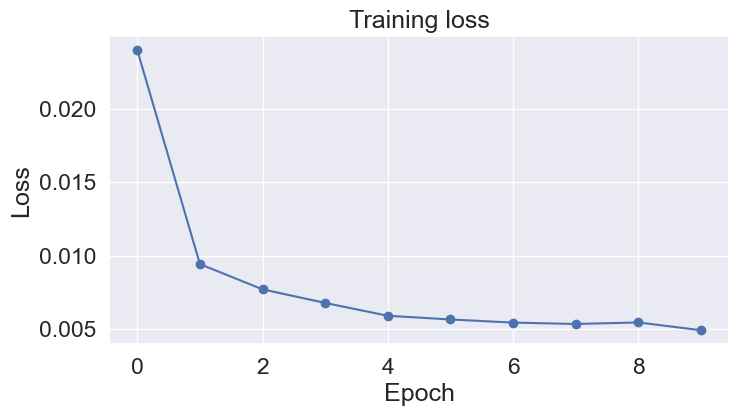

In [85]:
%matplotlib inline

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (8,4)

# Plot the learning curve.
plt.plot(train_loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

## J. Evaluation

### 1. Validation dataset - Evaluate Performance of trained Model
<p>
With our <font color=blue> model trained </font>, it's time to assess how well it performs on the test set, which consists of 10% of the seen data.

Keep in mind that during this evaluation,
1. we won't be making any gradient updates;
2. the model will simply provide its logits.
</p>

### 1.1. Predicting labels for sentences in valid dataset

In [86]:
print('Predicting labels for {:,} validation sentences...'.format(valid_size))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions_for_valid , true_labels_for_valid = [], []

# Do Predictions
for batch in valid_dataloader:
    # Add batch to GPU if available
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    batch_input_ids, batch_input_mask, batch_labels = batch

    # Telling the model not to compute or store gradients, saving memory
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(batch_input_ids, token_type_ids=None, 
                      attention_mask=batch_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions_for_valid.append(logits)
        true_labels_for_valid.append(label_ids)

print("Done")

Predicting labels for 3,274 validation sentences...
Done


#### 1.2. Computing the Performance Metrics on Validation Dataset

In [87]:
# First, combine the results across the batches.
all_predictions_for_valid = np.concatenate(predictions_for_valid, axis=0)
all_true_labels_for_valid = np.concatenate(true_labels_for_valid, axis=0)

print("After flattening the batches, the predictions have shape:")
print("    ", all_predictions_for_valid.shape)
# [valid_size x seq_len x num_labels]

# Next, let's remove the third dimension (axis 2), which has the scores
# for all 17 labels.

# For each token, pick the label with the highest score.
predicted_label_ids_for_valid = np.argmax(all_predictions_for_valid, axis=2)

print("\nAfter choosing the highest scoring label for each token, prediction label ids have shape:")
print("    ", predicted_label_ids_for_valid.shape)

# Eliminate axis 0, which corresponds to the sentences.
predicted_label_ids_for_valid = np.concatenate(predicted_label_ids_for_valid, axis=0)
all_true_labels_for_valid = np.concatenate(all_true_labels_for_valid, axis=0)


print("\nAfter flattening the sentences, the predictions have shape:")
print("    ", predicted_label_ids_for_valid.shape)

print("and ground truth have shape:")
print("    ", all_true_labels_for_valid.shape)

After flattening the batches, the predictions have shape:
     (3274, 128, 17)

After choosing the highest scoring label for each token, prediction label ids have shape:
     (3274, 128)

After flattening the sentences, the predictions have shape:
     (419072,)
and ground truth have shape:
     (419072,)


### 1.3. Removing the null id tokens (=-100) (a.k.a ignore tokens)

In [88]:
# Construct new lists of predictions which don't include any null tokens.
real_token_predictions_for_valid = []
real_token_labels_for_valid = []

# For each of the input tokens in the true labels of validation dataset...
for i in range(len(all_true_labels_for_valid)):

    # If it's not a token with a null label id ( = -100 ) ...
    if not all_true_labels_for_valid[i] == -100:
        
        # Add the prediction and the ground truth to their lists.
        real_token_predictions_for_valid.append(predicted_label_ids_for_valid[i])
        real_token_labels_for_valid.append(all_true_labels_for_valid[i])

print("Before filtering out `null` tokens, length = {:,}".format(len(all_true_labels_for_valid)))
print("After filtering out `null` tokens, length = {:,}".format(len(real_token_labels_for_valid)))

print(f"\ni.e total num of unwanted labels id (=-100) for which we dont need predictions are: {
len(all_true_labels_for_valid) - len(real_token_labels_for_valid)}")

Before filtering out `null` tokens, length = 419,072
After filtering out `null` tokens, length = 83,592

i.e total num of unwanted labels id (=-100) for which we dont need predictions are: 335480


#### 1.4. Computing classfication report - Accuracy, precision, recall and f1 score (micro, macro and weighted)

In [89]:
# computing the accuracy
accuracy_for_valid = accuracy_score(y_true=real_token_labels_for_valid,
                                    y_pred=real_token_predictions_for_valid)

print("accuracy score: {:.2%}".format(accuracy_for_valid))

# compute the macro precision
macro_precision_for_valid = precision_score(y_true=real_token_labels_for_valid,
                                            y_pred=real_token_predictions_for_valid,
                                            average='macro', zero_division=np.nan)
# compute the macro recall
macro_recall_for_valid = recall_score(y_true=real_token_labels_for_valid,
                                      y_pred=real_token_predictions_for_valid,
                                      average='macro')
# compute the macro f1_score
macro_f1_score_for_valid = f1_score(y_true = real_token_labels_for_valid,
                                    y_pred = real_token_predictions_for_valid,
                                    average='macro')

print("----- macro scores --------")
print("macro precision score: {:.3%}".format(macro_precision_for_valid))
print("macro recall score: {:.3%}".format(macro_recall_for_valid))
print("macro f1 score: {:.3%}".format(macro_f1_score_for_valid))

# ---- micro scores -------
micro_precision_for_valid = precision_score(y_true=real_token_labels_for_valid,
                                            y_pred=real_token_predictions_for_valid,
                                            average='micro', zero_division=np.nan)

micro_recall_for_valid = recall_score(y_true=real_token_labels_for_valid,
                                      y_pred=real_token_predictions_for_valid,
                                      average='micro')

micro_f1_score_for_valid = f1_score(y_true = real_token_labels_for_valid,
                                    y_pred = real_token_predictions_for_valid,
                                    average='micro')


print("----- micro scores --------")
print("micro precision score: {:.2%}".format(micro_precision_for_valid))
print("micro recall score: {:.2%}".format(micro_recall_for_valid))
print("micro f1 score: {:.2%}".format(micro_f1_score_for_valid))

# ------ weighted scores------

wt_precision_for_valid = precision_score(y_true=real_token_labels_for_valid,
                                            y_pred=real_token_predictions_for_valid,
                                            average='weighted', zero_division=np.nan)

wt_recall_for_valid = recall_score(y_true=real_token_labels_for_valid,
                                      y_pred=real_token_predictions_for_valid,
                                      average='weighted')

wt_f1_score_for_valid = f1_score(y_true = real_token_labels_for_valid,
                                    y_pred = real_token_predictions_for_valid,
                                    average='weighted')

print("----- weighted scores --------")
print("weighted precision score: {:.2%}".format(wt_precision_for_valid))
print("weighted recall score: {:.2%}".format(wt_recall_for_valid))
print("weighted f1 score: {:.2%}".format(wt_f1_score_for_valid))

accuracy score: 94.27%
----- macro scores --------
macro precision score: 80.762%
macro recall score: 45.134%
macro f1 score: 45.856%
----- micro scores --------
micro precision score: 94.27%
micro recall score: 94.27%
micro f1 score: 94.27%
----- weighted scores --------
weighted precision score: 94.17%
weighted recall score: 94.27%
weighted f1 score: 94.01%


#### 1.5 Confusion Matrix

In [90]:
label_names_ = list(label2idx.keys())
label_ids_ = [i for i in range(len(label_names_))]

# compute confusion matrix collectively
cm_for_valid = confusion_matrix(y_true=real_token_labels_for_valid,
                                y_pred=real_token_predictions_for_valid,
                                labels=label_ids_,
                               )

# compute multilabel confusion matrix
# Here it will compute cm at the class level
# labels are binarized under a one-vs-rest way
mcm_for_valid = multilabel_confusion_matrix(y_true=real_token_labels_for_valid,
                                        y_pred=real_token_predictions_for_valid,
                                        labels=label_ids_,
                                       )



df_cm_for_valid = pd.DataFrame(cm_for_valid, index=label_names_, columns=label_names_)

print("Confusion Matrix DataFrame")
df_cm_for_valid

Confusion Matrix DataFrame


,I-art,I-eve,B-art,B-eve,I-org,I-tim,I-gpe,B-per,B-org,O,B-geo,I-per,I-geo,B-tim,B-nat,I-nat,B-gpe
I-art,0,0,0,0,14,0,0,0,0,8,0,7,2,0,0,0,0
I-eve,0,0,0,0,9,2,0,0,0,8,0,0,0,2,0,0,0
B-art,0,0,0,0,1,0,0,2,25,12,14,0,1,0,0,0,2
B-eve,0,0,0,0,1,7,0,0,4,7,7,0,1,3,0,0,2
I-org,0,0,0,0,823,1,0,32,93,242,37,246,68,0,0,0,6
I-tim,0,0,0,0,5,280,0,4,1,164,6,5,1,119,0,0,4
I-gpe,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,8
B-per,0,0,0,0,8,0,0,1681,61,56,77,115,2,1,0,0,15
B-org,0,0,0,0,45,1,0,153,1495,248,397,75,3,4,0,0,66
O,0,0,0,0,226,13,0,55,214,64758,153,48,28,134,0,0,93


#### 1.6. Plot the confusion matrix for valid dataset

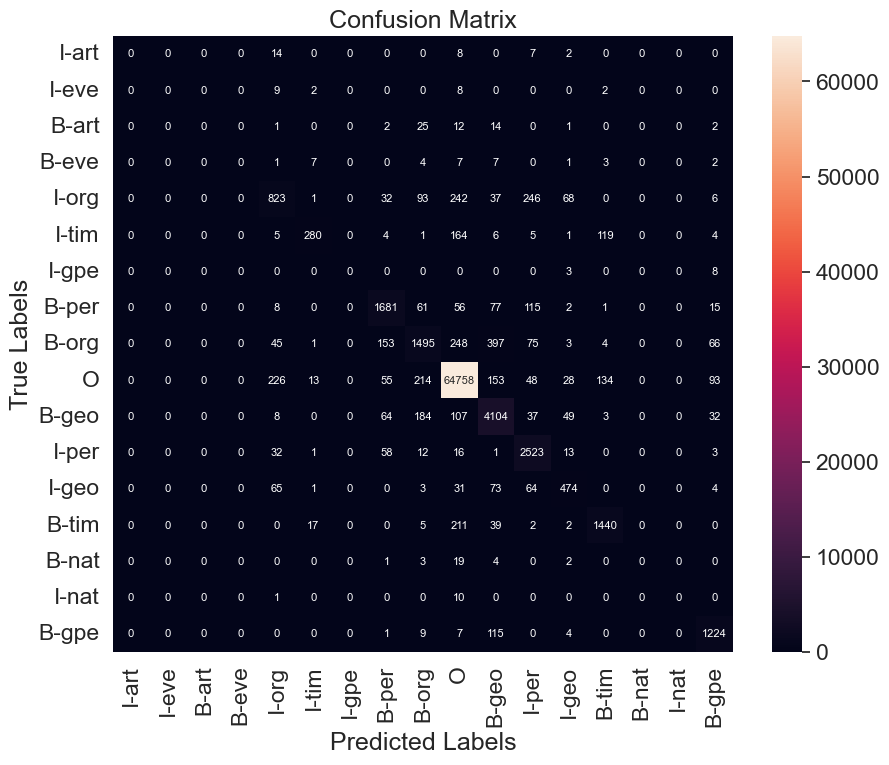

In [91]:
#specify size of heatmap
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(df_cm_for_valid, annot=True, fmt="g", annot_kws={"size": 8}).set(title='Confusion Matrix')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# get current figure to save
#fig_cm_valid = plt.gcf()

# show the plot
plt.show()
# save the fig
#fig_cm_valid.savefig('valid_cm.png', bbox_inches='tight', dpi=1600)

#### 1.7. Label-Wise Classification report 

In [92]:
from sklearn.metrics import classification_report

clf_report_for_valid = classification_report(y_true=real_token_labels_for_valid,
                                             y_pred=real_token_predictions_for_valid,
                                             labels=[x for x in range(len(label2idx))],
                                             target_names=list(label2idx.keys()),
                                             zero_division=0
                                            )

print("Classification Report for each label\n")
print(clf_report_for_valid)

Classification Report for each label

              precision    recall  f1-score   support

       I-art       0.00      0.00      0.00        31
       I-eve       0.00      0.00      0.00        21
       B-art       0.00      0.00      0.00        57
       B-eve       0.00      0.00      0.00        32
       I-org       0.66      0.53      0.59      1548
       I-tim       0.87      0.48      0.61       589
       I-gpe       0.00      0.00      0.00        11
       B-per       0.82      0.83      0.83      2016
       B-org       0.71      0.60      0.65      2487
           O       0.98      0.99      0.98     65722
       B-geo       0.82      0.89      0.85      4588
       I-per       0.81      0.95      0.87      2659
       I-geo       0.73      0.66      0.69       715
       B-tim       0.84      0.84      0.84      1716
       B-nat       0.00      0.00      0.00        29
       I-nat       0.00      0.00      0.00        11
       B-gpe       0.84      0.90      0.87

#### 1.8. Confusion Matrix for each Label (One Vs All Fashion)

In [93]:
# Label wise confusin matrix (one vs all fashion)
for label_, l_cm in zip(label_names_, mcm_for_valid):
    col_names_ = [f"not_{label_}",label_]
    print(f"Confusion Matrix for {label_}")
    ldf = pd.DataFrame(l_cm, index=col_names_, columns=col_names_)
    display(ldf)
    print("-----------------------------\n")

Confusion Matrix for I-art


,not_I-art,I-art
not_I-art,83561,0
I-art,31,0


-----------------------------

Confusion Matrix for I-eve


,not_I-eve,I-eve
not_I-eve,83571,0
I-eve,21,0


-----------------------------

Confusion Matrix for B-art


,not_B-art,B-art
not_B-art,83535,0
B-art,57,0


-----------------------------

Confusion Matrix for B-eve


,not_B-eve,B-eve
not_B-eve,83560,0
B-eve,32,0


-----------------------------

Confusion Matrix for I-org


,not_I-org,I-org
not_I-org,81629,415
I-org,725,823


-----------------------------

Confusion Matrix for I-tim


,not_I-tim,I-tim
not_I-tim,82960,43
I-tim,309,280


-----------------------------

Confusion Matrix for I-gpe


,not_I-gpe,I-gpe
not_I-gpe,83581,0
I-gpe,11,0


-----------------------------

Confusion Matrix for B-per


,not_B-per,B-per
not_B-per,81206,370
B-per,335,1681


-----------------------------

Confusion Matrix for B-org


,not_B-org,B-org
not_B-org,80491,614
B-org,992,1495


-----------------------------

Confusion Matrix for O


,not_O,O
not_O,16724,1146
O,964,64758


-----------------------------

Confusion Matrix for B-geo


,not_B-geo,B-geo
not_B-geo,78081,923
B-geo,484,4104


-----------------------------

Confusion Matrix for I-per


,not_I-per,I-per
not_I-per,80334,599
I-per,136,2523


-----------------------------

Confusion Matrix for I-geo


,not_I-geo,I-geo
not_I-geo,82698,179
I-geo,241,474


-----------------------------

Confusion Matrix for B-tim


,not_B-tim,B-tim
not_B-tim,81610,266
B-tim,276,1440


-----------------------------

Confusion Matrix for B-nat


,not_B-nat,B-nat
not_B-nat,83563,0
B-nat,29,0


-----------------------------

Confusion Matrix for I-nat


,not_I-nat,I-nat
not_I-nat,83581,0
I-nat,11,0


-----------------------------

Confusion Matrix for B-gpe


,not_B-gpe,B-gpe
not_B-gpe,81997,235
B-gpe,136,1224


-----------------------------



### 2. Preparing the Test dataset
<p>Preparing the <font color=brown><b>Test dataset</b></font> same as <b>training dataset</b> for predicting the results
    of our Trained model
</p>

#### 2.1. Create the input ids, attention mask for the test data

In [94]:
# compute the input ids, attention mask for each sentence in seen data
input_ids, attention_masks = get_input_ids_and_attention_masks(sentences=test_sentences,
                                                                 tokenizer=tokenizer,
                                                                 max_length=MAX_PAD_LEN)

##### Peek into 1st sentence's input ids, attention masks

In [96]:
print('Original: ', test_sentences[0])
print('\nToken IDs:', input_ids[0])
print('\nMasks:', attention_masks[0])

Original:  ['Abu', 'Farraj', 'al-Libbi', ',', 'a', 'top', 'al-Qaida', 'operative', 'and', 'close', 'associate', 'of', 'Osama', 'bin', 'Laden', 'who', 'is', 'wanted', 'for', 'two', 'attempts', 'to', 'assassinate', 'Pakistani', 'President', 'Pervez', 'Musharraf', ',', 'has', 'been', 'arrested', 'in', 'Pakistan', '.']

Token IDs: tensor([  101,  8273,  2521, 14220,  2632,  1011,  5622, 10322,  2072,  1010,
         1037,  2327,  2632,  1011,  1053, 14326,  2050, 12160,  1998,  2485,
         5482,  1997,  9808,  8067,  8026, 14887,  2040,  2003,  2359,  2005,
         2048,  4740,  2000, 25683,  9889,  2343,  2566, 26132, 14163,  7377,
        11335,  2546,  1010,  2038,  2042,  4727,  1999,  4501,  1012,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     

#### 2.2. Compute the final token labels (of max sequence length) for each sentence 

In [97]:
token_labels = match_tokens_labels(test_sentences, test_labels, label2idx_map=label2idx,
                                   max_pad_len=MAX_PAD_LEN, ignore_token = -100)

##### Lets view a sample sentence, original word labels and its corresponding tokenized sentence, input ids, attention masks, token labels 

In [98]:
print('\nSentence:    ', test_sentences[2])
print('\nLabels:      ', test_labels[2])
print('\nBERT Tokens: ', tokenizer.tokenize(' '.join(test_sentences[2])))
print('\nToken IDs:   ', input_ids[2])
print('\nNew Labels:  ', token_labels[2])
print('\nMask:        ', attention_masks[2])


Sentence:     ['Persistent', 'concerns', 'about', 'economic', 'and', 'political', 'instability', 'have', 'also', 'contributed', 'to', 'a', 'decline', 'in', 'Pakistani', 'stocks', '.']

Labels:       ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O']

BERT Tokens:  ['persistent', 'concerns', 'about', 'economic', 'and', 'political', 'instability', 'have', 'also', 'contributed', 'to', 'a', 'decline', 'in', 'pakistani', 'stocks', '.']

Token IDs:    tensor([  101, 14516,  5936,  2055,  3171,  1998,  2576, 18549,  2031,  2036,
         5201,  2000,  1037,  6689,  1999,  9889, 15768,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,

#### 2.3. Convert the list into pyTorch Tensors

In [99]:
import torch

# pytorch tensor for input ids
pt_input_ids = torch.stack(input_ids, dim=0)

# pytorch tensor for attention masks
pt_attention_masks = torch.stack(attention_masks, dim=0)

# pytorch tensor for labels
pt_labels = torch.tensor(token_labels, dtype=torch.long)

##### Check the shapes

In [100]:
pt_input_ids.shape, pt_attention_masks.shape, pt_labels.shape

(torch.Size([8184, 128]), torch.Size([8184, 128]), torch.Size([8184, 128]))

#### 2.4. Create Test TesnsorDataset

In [101]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
test_dataset = TensorDataset(pt_input_ids, pt_attention_masks, pt_labels)

#### 2.5. Convert tensors into Batches for batch wise testing
<p>We will use <b>SequentialSampler</b> for selecting the batch Sequentially</p>

In [102]:
from torch.utils.data import DataLoader, SequentialSampler

# set the batch size
batch_size = 32

# load the validation dataset
test_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset),
                                   batch_size = batch_size)

#### 2.6. Prediction on Test Dataset

In [103]:
print('Predicting labels for {:,} test sentences...'.format(len(pt_input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions_for_test , true_labels_for_test = [], []

# Do Predictions
for batch in test_dataloader:
    # Add batch to GPU if available
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    batch_input_ids, batch_input_mask, batch_labels = batch

    # Telling the model not to compute or store gradients, saving memory and 
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(batch_input_ids, token_type_ids=None, 
                      attention_mask=batch_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = batch_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions_for_test.append(logits)
        true_labels_for_test.append(label_ids)
print("Done")

Predicting labels for 8,184 test sentences...
Done


#### 2.7. Computing the Performance Metrics on Validation Dataset

In [104]:
# Each elem of prediction for valid is a list of size 32 = batch size

# First, combine the results across the batches.
all_predictions_for_test = np.concatenate(predictions_for_test, axis=0)
all_true_labels_for_test = np.concatenate(true_labels_for_test, axis=0)

print("After flattening the batches, the predictions have shape:")
print("    ", all_predictions_for_test.shape)

# Next, let's remove the third dimension (axis 2), which has the scores
# for all 18 labels.

# For each token, pick the label with the highest score.
predicted_label_ids_for_test = np.argmax(all_predictions_for_test, axis=2)

print("\nAfter choosing the highest scoring label for each token, prediction label ids have shape:")
print("    ", predicted_label_ids_for_test.shape)

# Eliminate axis 0, which corresponds to the sentences.
predicted_label_ids_for_test = np.concatenate(predicted_label_ids_for_test, axis=0)
all_true_labels_for_test = np.concatenate(all_true_labels_for_test, axis=0)


print("\nAfter flattening the sentences, the predictions have shape:")
print("    ", predicted_label_ids_for_test.shape)

print("and ground truth have shape:")
print("    ", all_true_labels_for_test.shape)

After flattening the batches, the predictions have shape:
     (8184, 128, 17)

After choosing the highest scoring label for each token, prediction label ids have shape:
     (8184, 128)

After flattening the sentences, the predictions have shape:
     (1047552,)
and ground truth have shape:
     (1047552,)


### 2.8. Removing the null id tokens (=-100) (a.k.a ignore tokens)

In [105]:
# Construct new lists of predictions which don't include any null tokens.
real_token_predictions_for_test = []
real_token_labels_for_test = []

# For each of the input tokens in the true labels of validation dataset...
for i in range(len(all_true_labels_for_test)):

    # If it's not a token with a null label id ( = -100 ) ...
    if not all_true_labels_for_test[i] == -100:
        
        # Add the prediction and the ground truth to their lists.
        real_token_predictions_for_test.append(predicted_label_ids_for_test[i])
        real_token_labels_for_test.append(all_true_labels_for_test[i])

print("Before filtering out `null` tokens, length = {:,}".format(len(all_true_labels_for_test)))
print("After filtering out `null` tokens, length = {:,}".format(len(real_token_labels_for_test)))

print(f"\ni.e total num of unwanted labels id (=-100) for which we dont need predictions are: {
len(all_true_labels_for_test) - len(real_token_labels_for_test)}")

Before filtering out `null` tokens, length = 1,047,552
After filtering out `null` tokens, length = 209,464

i.e total num of unwanted labels id (=-100) for which we dont need predictions are: 838088


#### 2.9. Compute Overall classfication report - Accuracy, precision, recall and f1 score (both micro and macro)

In [106]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

# computing the accuracy
accuracy_for_test = accuracy_score(y_true=real_token_labels_for_test,
                                    y_pred=real_token_predictions_for_test)

print("accuracy score: {:.2%}".format(accuracy_for_test))

# compute the macro precision
macro_precision_for_test = precision_score(y_true=real_token_labels_for_test,
                                            y_pred=real_token_predictions_for_test,
                                            average='macro', zero_division=np.nan)
# compute the macro recall
macro_recall_for_test = recall_score(y_true=real_token_labels_for_test,
                                      y_pred=real_token_predictions_for_test,
                                      average='macro')
# compute the macro f1_score
macro_f1_score_for_test = f1_score(y_true = real_token_labels_for_test,
                                    y_pred = real_token_predictions_for_test,
                                    average='macro')

print("----- macro scores --------")
print("macro precision score: {:.3%}".format(macro_precision_for_test))
print("macro recall score: {:.3%}".format(macro_recall_for_test))
print("macro f1 score: {:.3%}".format(macro_f1_score_for_test))


micro_precision_for_test = precision_score(y_true=real_token_labels_for_test,
                                            y_pred=real_token_predictions_for_test,
                                            average='micro', zero_division=np.nan)

micro_recall_for_test = recall_score(y_true=real_token_labels_for_test,
                                      y_pred=real_token_predictions_for_test,
                                      average='micro')

micro_f1_score_for_test = f1_score(y_true = real_token_labels_for_test,
                                    y_pred = real_token_predictions_for_test,
                                    average='micro')

print("----- micro scores --------")
print("micro precision score: {:.2%}".format(micro_precision_for_test))
print("micro recall score: {:.2%}".format(micro_recall_for_test))
print("micro f1 score: {:.2%}".format(micro_f1_score_for_test))

accuracy score: 94.08%
----- macro scores --------
macro precision score: 80.150%
macro recall score: 45.140%
macro f1 score: 45.807%
----- micro scores --------
micro precision score: 94.08%
micro recall score: 94.08%
micro f1 score: 94.08%


#### 2.10. Confusion Matrix - Test Data

In [107]:
# compute confusion matrix collectively
cm_for_test = confusion_matrix(y_true=real_token_labels_for_test,
                                y_pred=real_token_predictions_for_test,
                                labels=label_ids_,
                               )

# compute multilabel confusion matrix
# Here it will compute cm at the class level
# labels are binarized under a one-vs-rest way
mcm_for_test = multilabel_confusion_matrix(y_true=real_token_labels_for_test,
                                        y_pred=real_token_predictions_for_test,
                                        labels=label_ids_,
                                       )



df_cm_for_test = pd.DataFrame(cm_for_test, index=label_names_, columns=label_names_)

print("Confusion Matrix DataFrame for Test Data")
df_cm_for_test

Confusion Matrix DataFrame for Test Data


,I-art,I-eve,B-art,B-eve,I-org,I-tim,I-gpe,B-per,B-org,O,B-geo,I-per,I-geo,B-tim,B-nat,I-nat,B-gpe
I-art,0,0,0,0,28,1,0,0,8,26,2,3,3,0,0,0,0
I-eve,0,0,0,0,10,10,0,0,1,17,0,1,7,1,0,0,0
B-art,0,0,0,0,5,0,0,11,75,44,13,0,0,0,0,0,4
B-eve,0,0,0,0,3,10,0,1,5,25,6,0,1,6,0,0,3
I-org,0,0,0,0,2218,4,0,96,180,641,112,548,201,6,0,0,17
I-tim,0,0,0,0,10,693,0,1,8,306,30,6,7,282,0,0,1
I-gpe,0,0,0,0,0,0,0,0,0,5,2,0,15,0,0,0,23
B-per,0,0,0,0,22,0,0,4178,231,135,149,378,5,3,0,0,27
B-org,0,0,0,0,129,3,0,436,4034,637,1198,173,15,13,0,0,109
O,0,0,0,0,602,60,0,160,547,161663,388,166,61,307,0,0,215


#### 2.11. Plotting Confusion Matrix - Test Data

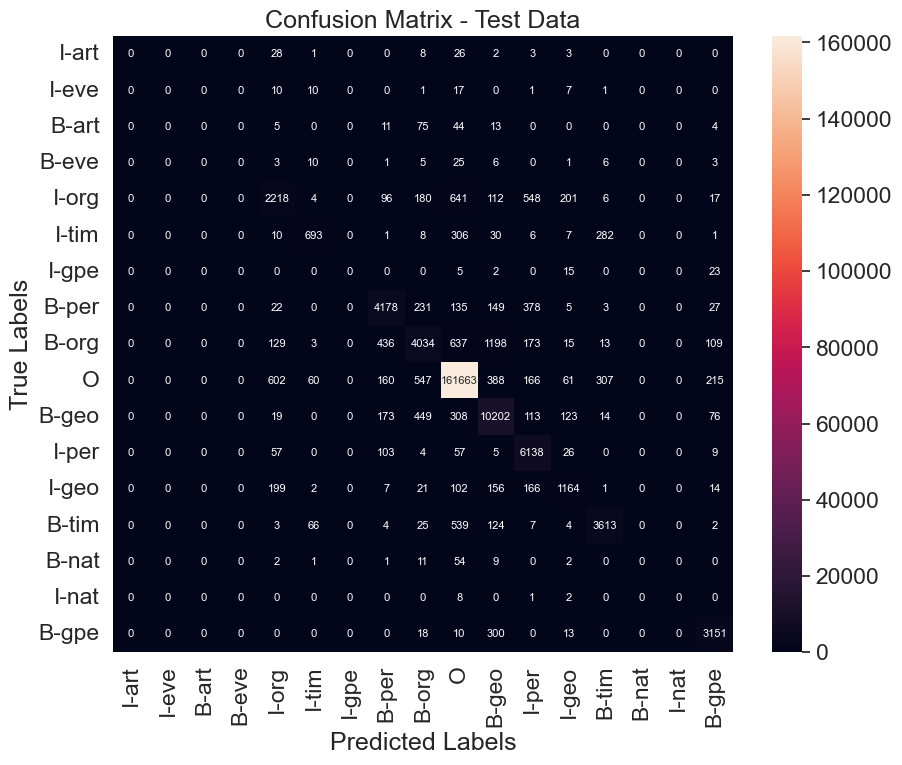

In [108]:
#specify size of heatmap
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(df_cm_for_test, annot=True, fmt="g", annot_kws={"size": 8}).set(title='Confusion Matrix - Test Data')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
#fig.savefig('test_cm.png', bbox_inches='tight', dpi=1600)

#### 2.12. Compute the Label-Level Classification report for Test Dataset

In [109]:
from sklearn.metrics import classification_report

clf_report_for_test = classification_report(y_true=real_token_labels_for_test,
                                             y_pred=real_token_predictions_for_test,
                                             labels=[x for x in range(len(label2idx))],
                                             target_names=list(label2idx.keys()),
                                             zero_division=0
                                            )

print(clf_report_for_test)

              precision    recall  f1-score   support

       I-art       0.00      0.00      0.00        71
       I-eve       0.00      0.00      0.00        47
       B-art       0.00      0.00      0.00       152
       B-eve       0.00      0.00      0.00        60
       I-org       0.67      0.55      0.61      4023
       I-tim       0.82      0.52      0.63      1344
       I-gpe       0.00      0.00      0.00        45
       B-per       0.81      0.81      0.81      5128
       B-org       0.72      0.60      0.65      6747
           O       0.98      0.98      0.98    164169
       B-geo       0.80      0.89      0.84     11477
       I-per       0.80      0.96      0.87      6399
       I-geo       0.71      0.64      0.67      1832
       B-tim       0.85      0.82      0.84      4387
       B-nat       0.00      0.00      0.00        80
       I-nat       0.00      0.00      0.00        11
       B-gpe       0.86      0.90      0.88      3492

    accuracy              

#### 2.13. Compute Confusion Matrix for each label (One Vs All Fashion)

In [110]:
# Label wise confusin matrix (one vs all fashion)
for label_, l_cm in zip(label_names_, mcm_for_test):
    col_names_ = [f"not_{label_}",label_]
    print(f"Confusion Matrix for {label_}")
    ldf = pd.DataFrame(l_cm, index=col_names_, columns=col_names_)
    display(ldf)
    print("-----------------------------\n")

Confusion Matrix for I-art


,not_I-art,I-art
not_I-art,209393,0
I-art,71,0


-----------------------------

Confusion Matrix for I-eve


,not_I-eve,I-eve
not_I-eve,209417,0
I-eve,47,0


-----------------------------

Confusion Matrix for B-art


,not_B-art,B-art
not_B-art,209312,0
B-art,152,0


-----------------------------

Confusion Matrix for B-eve


,not_B-eve,B-eve
not_B-eve,209404,0
B-eve,60,0


-----------------------------

Confusion Matrix for I-org


,not_I-org,I-org
not_I-org,204352,1089
I-org,1805,2218


-----------------------------

Confusion Matrix for I-tim


,not_I-tim,I-tim
not_I-tim,207963,157
I-tim,651,693


-----------------------------

Confusion Matrix for I-gpe


,not_I-gpe,I-gpe
not_I-gpe,209419,0
I-gpe,45,0


-----------------------------

Confusion Matrix for B-per


,not_B-per,B-per
not_B-per,203343,993
B-per,950,4178


-----------------------------

Confusion Matrix for B-org


,not_B-org,B-org
not_B-org,201134,1583
B-org,2713,4034


-----------------------------

Confusion Matrix for O


,not_O,O
not_O,42381,2914
O,2506,161663


-----------------------------

Confusion Matrix for B-geo


,not_B-geo,B-geo
not_B-geo,195493,2494
B-geo,1275,10202


-----------------------------

Confusion Matrix for I-per


,not_I-per,I-per
not_I-per,201503,1562
I-per,261,6138


-----------------------------

Confusion Matrix for I-geo


,not_I-geo,I-geo
not_I-geo,207147,485
I-geo,668,1164


-----------------------------

Confusion Matrix for B-tim


,not_B-tim,B-tim
not_B-tim,204444,633
B-tim,774,3613


-----------------------------

Confusion Matrix for B-nat


,not_B-nat,B-nat
not_B-nat,209384,0
B-nat,80,0


-----------------------------

Confusion Matrix for I-nat


,not_I-nat,I-nat
not_I-nat,209453,0
I-nat,11,0


-----------------------------

Confusion Matrix for B-gpe


,not_B-gpe,B-gpe
not_B-gpe,205472,500
B-gpe,341,3151


-----------------------------



## K. Testing the Trained Model
<p>In this section we will test out <b>trained model</b> on a given sentence in Test Data by its <b>index number</b> on test dataset</p>

In [112]:
print("Every test sentence has an index number associated with it.")
print("\nTo see the prediction labels for a test sentence,")
print(f"please enter a number, between 0 and {len(test_sentences)-1}")

Every test sentence has an index number associated with it.

To see the prediction labels for a test sentence,
please enter a number, between 0 and 8183


### 1. Enter the index of test sentence to be tested

In [113]:
test_sentence_num = int(input ("Enter index :") )

Enter index : 1


In [114]:
print(f"Entered number is: {test_sentence_num}\n")
print(f"The sentence associated with index {test_sentence_num} is:\n")
test_sentence = test_sentences[test_sentence_num]
print(f"test sentence: {test_sentence}")
test_label = test_labels[test_sentence_num]
print(f"test labels: {test_label}")

Entered number is: 1

The sentence associated with index 1 is:

test sentence: ['Meanwhile', ',', 'Iraq', "'s", 'interim', 'government', 'said', 'the', 'country', "'s", 'borders', 'will', 'be', 'closed', 'for', 'five', 'days', 'from', 'February', '17', '-', 'apparently', 'to', 'boost', 'security', 'during', 'the', 'major', "Shi'ite", 'Muslim', 'religious', 'observance', 'of', 'Ashura', '.']
test labels: ['O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'B-tim', 'I-tim', 'I-tim', 'I-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'I-geo', 'O', 'O', 'B-geo', 'I-geo', 'O']


### 2. Checking the Results

In [115]:
# To see all the columns of pandas df
pd.set_option('display.max_columns', None)

# Encoding and convert the sentences into tensors
sample_sentence = tokenizer.encode(' '.join(test_sentence))
sample_input_ids = torch.tensor([sample_sentence]).to(device)


# Predicting the test sample using model() function
with torch.no_grad():
    output = model(sample_input_ids)

# Extract the labels
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

# Function which retrieves key value for our Label Dictionary
# Note: For words that don't exist we will simply use the label "O"
def get_key(val):
    for key, value in label2idx.items():
         if val == value:
             return key
    return "O"

#Tokenize  
tokens = tokenizer.convert_ids_to_tokens(sample_input_ids.to('cpu').numpy()[0])
new_tokens, new_label = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_label.append(get_key(label_idx))
        new_tokens.append(token)
print(new_tokens)

#Appending Tokens and Labels
sample_token=[]
sample_label=[]
for token, label in zip(new_tokens, new_label):
    sample_token.append(token) 
    sample_label.append(label)

['[CLS]', 'meanwhile', ',', 'iraq', "'", 's', 'interim', 'government', 'said', 'the', 'country', "'", 's', 'borders', 'will', 'be', 'closed', 'for', 'five', 'days', 'from', 'february', '17', '-', 'apparently', 'to', 'boost', 'security', 'during', 'the', 'major', 'shi', "'", 'ite', 'muslim', 'religious', 'observance', 'of', 'ashura', '.', '[SEP]']


### 3. Visualize the raw output

In [116]:
df=pd.DataFrame({"Token":sample_token,"sample label":sample_label})
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40
Token,[CLS],meanwhile,",",iraq,',s,interim,government,said,the,country,',s,borders,will,be,closed,for,five,days,from,february,17,-,apparently,to,boost,security,during,the,major,shi,',ite,muslim,religious,observance,of,ashura,.,[SEP]
sample label,O,O,O,B-geo,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-tim,O,O,B-tim,I-tim,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-geo,O,O


### 4. Processing Raw Prediction

<p>As we can see in the <b>raw output</b>, the total number of tokens can be <b>greater</b> than the length of test sentence.
    
As per the requirements of the Project, we need to ensure that individual <font color=brown>word pieces</font> are futher clubbed
into <font color=brown>one single word</font> (as present in the original test sentence) so that length of sample token is equal
to length of clean tokens. Hence we will create a function to achieve the same.

Also we don't need <b>special tokens</b> at the begining and at the end of a sentence.
</p>

In [117]:
def preprocess_raw_prediction(test_sentence, sample_token, sample_label):
    # remove special tokens and corresponding labels
    # they are not required
    filter_tokens = sample_token[1:-1]
    filter_labels = sample_label[1:-1]

    # Result stored in list as token, label pair
    res = []
    # initial index for list of sample tokens
    tok_idx = 0
    
    # iterate through each token of test sentence
    for word in test_sentence:
        # pair to store the current word and its label
        pair = tuple()
        # check the length of current word
        word_len = len(word)
        # check the length of current token in sample tokens
        tok_len = len(filter_tokens[tok_idx])

        # Note: We are using the strategy that will
        # assume that 1st word piece label is the 
        # label for the entire word.
        # Hence, get the label for current token
        tok_labl =  filter_labels[tok_idx]

        # update the pair
        pair = (word, tok_labl)

        # increment the idx till word_len becomes equal to tok len
        while word_len > tok_len:
            # increment token idex
            tok_idx +=1
            # add the length of next token
            tok_len += len(filter_tokens[tok_idx])
        tok_idx+=1
        res.append(pair)
    return res

#### 5. Compute the clean Prediction

In [118]:
# compute the prediction result
res = preprocess_raw_prediction(test_sentence, sample_token, sample_label)
# print token and their predicted label in pairs
print(res)

[('Meanwhile', 'O'), (',', 'O'), ('Iraq', 'B-geo'), ("'s", 'O'), ('interim', 'O'), ('government', 'O'), ('said', 'O'), ('the', 'O'), ('country', 'O'), ("'s", 'O'), ('borders', 'O'), ('will', 'O'), ('be', 'O'), ('closed', 'O'), ('for', 'O'), ('five', 'B-tim'), ('days', 'O'), ('from', 'O'), ('February', 'B-tim'), ('17', 'I-tim'), ('-', 'O'), ('apparently', 'O'), ('to', 'O'), ('boost', 'O'), ('security', 'O'), ('during', 'O'), ('the', 'O'), ('major', 'O'), ("Shi'ite", 'O'), ('Muslim', 'O'), ('religious', 'O'), ('observance', 'O'), ('of', 'O'), ('Ashura', 'B-geo'), ('.', 'O')]


### 6. View clean Predictions as a DataFrame

In [119]:
# create DataFrame using data
df = pd.DataFrame(data=res, columns=['Token','Pred_Label'])
df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
Token,Meanwhile,",",Iraq,'s,interim,government,said,the,country,'s,borders,will,be,closed,for,five,days,from,February,17,-,apparently,to,boost,security,during,the,major,Shi'ite,Muslim,religious,observance,of,Ashura,.
Pred_Label,O,O,B-geo,O,O,O,O,O,O,O,O,O,O,O,O,B-tim,O,O,B-tim,I-tim,O,O,O,O,O,O,O,O,O,O,O,O,O,B-geo,O


##### ********************************* Testing Ends Here ******************************************************

## L. Helper Functions to cosolidate the logic we have defined in above cells
<p>
We will create the following functions:
    
1. <b>create_input_ids</b> - Function to create <font color=brown>Input Ids</font> for a given sentence
2. <b>make_raw_prediction</b> - Function to compute <font color=brown>raw predictions</font>
3. <b>make_prediction</b> - Function to compute <font color=brown>CLEAN predictions</font> (as required by the Project)

And then we will check the final prediction on the test sentence that
we used in Testing Phase defined above
</p>

#### 1. Create a function to produce input id sample for a sentence

In [120]:
def create_input_ids(sentence, tokenizer):
    """
    Create sample input ids for a given sentence using the tokenizer
    """
    # Encoding and convert the sentences into tensors
    sample_sentence = tokenizer.encode(' '.join(sentence))
    sample_input_ids = torch.tensor([sample_sentence])
    
    return sample_input_ids

#### 2. Create a function to produce raw prediction for a sentence

In [121]:
def make_raw_prediction(sentence, model, tokenizer, unseen_word_label='O', device='cpu'):
    
    # Function which retrieves key value for our Label Dictionary
    def get_key(val):
        for key, value in label2idx.items():
             if val == value:
                 return key
        return unseen_word_label

    try:
        device = torch.device(device)
    except:
        print(f"unable to move to device {device}. Hence using cpu.")
        device = torch.device('cpu')

    # move model to device
    model.to(device)
    
    # Create sample input ids
    sample_input_ids = create_input_ids(sentence, tokenizer)

    # move the input ids to device
    sample_input_ids.to(device)
    
    # Predicting the test sample using model() function
    with torch.no_grad():
        output = model(sample_input_ids)

    # Extract the labels
    label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
    
    #Tokenize  
    tokens = tokenizer.convert_ids_to_tokens(sample_input_ids.to('cpu').numpy()[0])

    # We need to club wordpieces starting with "##' in a single word
    new_tokens, new_label = [], []
    for token, label_idx in zip(tokens, label_indices[0]):
        if token.startswith("##"):
            new_tokens[-1] = new_tokens[-1] + token[2:]
        else:
            new_label.append(get_key(label_idx))
            new_tokens.append(token)

    #Appending Tokens and Labels
    sample_token=[]
    sample_label=[]
    for token, label in zip(new_tokens, new_label):
        sample_token.append(token) 
        sample_label.append(label)
        
    return sample_token, sample_label

#### 3. Create a function to compute clean prediction for a sentence

In [137]:
def make_prediction(sentence, model, tokenizer, unseen_word_label='O', sent_delimiter=" ", device='cpu'):
    
    # check if sentence is a list of words
    if isinstance(sentence, str):
        # create the string
        sentence = sentence.strip().split(sent_delimiter)

    # compute raw predictions
    sample_token, sample_label = make_raw_prediction(sentence, model, tokenizer, unseen_word_label, device)

    # preprocess raw prediction to make clean predictions
    clean_pred_ = preprocess_raw_prediction(sentence, sample_token, sample_label)

    return clean_pred_

#### 4. Lets check the make prediction function
<p>We will use the <b>same</b> test sentence that we used in testing phase, so that we can <b>verify</b> the result of the functions created above.</p>

In [123]:
# display the test sentence
print(f"test sentence:\n {" ".join(test_sentence)}")

# compute the clean predictions using the function 'make prediction'
pred_ = make_prediction(test_sentence, model, tokenizer, device='cpu')

# create dataframe for pred_ for better viewing
print("\nToken - Predicted Label Results")
df = pd.DataFrame(data=pred_, columns=['Token','Pred_Label'])
df.T

test sentence:
 Meanwhile , Iraq 's interim government said the country 's borders will be closed for five days from February 17 - apparently to boost security during the major Shi'ite Muslim religious observance of Ashura .

Token - Predicted Label Results


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34
Token,Meanwhile,",",Iraq,'s,interim,government,said,the,country,'s,borders,will,be,closed,for,five,days,from,February,17,-,apparently,to,boost,security,during,the,major,Shi'ite,Muslim,religious,observance,of,Ashura,.
Pred_Label,O,O,B-geo,O,O,O,O,O,O,O,O,O,O,O,O,B-tim,O,O,B-tim,I-tim,O,O,O,O,O,O,O,O,O,O,O,O,O,B-geo,O


# M. Inference

<p>
    The most <b>advantageous</b> aspect is the ability to swiftly evaluate the model using novel, previously <b>unencountered</b> sentences. In this
    context, we utilize the prediction of the initial word piece for each word.
</p>

### 1. Enter any sentence

In [140]:
sent_ = input("Enter any sentence:")

Enter any sentence: The company Sapient was founded on November 6, 1990, by Jerry Greenberg and J. Stuart Moore in Cambridge, Massachusetts


In [141]:
print(f"The sentence entered is:\n {sent_}")

# compute label predictions
pred_labels_ = make_prediction(sent_, model=model, tokenizer=tokenizer, device='cpu')

The sentence entered is:
 The company Sapient was founded on November 6, 1990, by Jerry Greenberg and J. Stuart Moore in Cambridge, Massachusetts


### 2. View Results as DataFrame

In [126]:
# compute the predictions
pred_df_ = pd.DataFrame(data=pred_labels_, columns=['Token', 'Labels'])
pred_df_.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Token,The,company,Sapient,was,founded,on,November,"6,","1990,",by,Jerry,Greenberg,and,J.,Stuart,Moore,in,"Cambridge,",Massachusetts
Labels,O,O,B-org,O,O,O,B-tim,I-tim,I-tim,O,B-per,I-per,O,B-per,I-per,I-per,O,B-geo,B-geo


<p> The <b>results</b> are very promising &#x1F60A</p>

## N. Saving And loading Utilities for the Model and Tokenizer

#### 1. Function to save and load the model & tokenizer

In [127]:
def save_model(model, saved_model_path):
    try:
        # save the state dict
        model.save_pretrained(saved_model_path)
        print(f"model saved successfully at {saved_model_path} ...")
        return True
    except Exception as e:
        print(f"ERROR: {e}")
        print("unable to save the model..")
    return False

def load_model(saved_model_path):
    try:
        # load the state dict
        model = BertForTokenClassification.from_pretrained(saved_model_path)
        print("model loaded successfully")
        return model
    except Exception as e:
        print(f"ERROR: {e}")
        print("unable to load the model..")
        return False


def save_tokenizer(tokenizer, saved_tokenizer_path):
    try:
        # save the state dict
        tokenizer.save_pretrained(saved_tokenizer_path, save_tokenizer=True)
        print(f"tokenizer saved successfully at {saved_tokenizer_path} ...")
        return True
    except Exception as e:
        print(f"ERROR: {e}")
        print("unable to save the model..")
    return False


def load_tokenizer(saved_tokenizer_path):
    try:
        # load the state dict
        tokenizer = BertTokenizer.from_pretrained(saved_tokenizer_path)
        print("tokenizer loaded successfully")
        return tokenizer
    except Exception as e:
        print(f"ERROR: {e}")
        print("unable to load the tokenizer..")
        return False

#### 2. Save the trained model

In [128]:
dir_to_save = "/Users/akg/jupyter/company_interview/sapient/bert_ner"
model_name = "BERT_NER_L_12"

model_dir_path = f"{dir_to_save}/{model_name}"

# save the model
save_model(model=model, saved_model_path=model_dir_path)

model saved successfully at /Users/akg/jupyter/company_interview/sapient/bert_ner/BERT_NER_L_12 ...


True

#### 3. Save the Tokenizer

In [129]:
dir_to_save = "/Users/akg/jupyter/company_interview/sapient/bert_ner"
tokenizer_name = "BERT_TOKENIZER"

tokenizer_dir_path = f"{dir_to_save}/{tokenizer_name}"

# save the model
save_tokenizer(tokenizer=tokenizer, saved_tokenizer_path=tokenizer_dir_path)

tokenizer saved successfully at /Users/akg/jupyter/company_interview/sapient/bert_ner/BERT_TOKENIZER ...


True

#### 4. Load the Model and Tokenizer (for future use)

In [130]:
# load the saved model
loaded_model = load_model(model_dir_path)

# load the saved tokenizer
loaded_tokenizer = load_tokenizer(tokenizer_dir_path)

model loaded successfully
tokenizer loaded successfully


#### 5. Lets check the Loaded model and tokenizer

In [131]:
new_sent_ = "In 2016 , the company merged two of its divisions , \
SapientNitro and Razorfish to form SapientRazorfish which was led by Alan Wexler .\
A few years later in 2019 , SapientRazorfish and Sapient Consulting were consolidated into one brand , \
Publicis Sapient under the leadership of CEO Nigel Vaz ."

In [132]:
# We will use loaded model and loaded tokenizer
new_pred_ = make_prediction(sentence=new_sent_, model=loaded_model, tokenizer=loaded_tokenizer, device='cpu')

#### 6. View pred as DF

In [133]:
new_df_ = pd.DataFrame(new_pred_, columns=['Token','Pred_Label'])
new_df_.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
Token,In,2016,",",the,company,merged,two,of,its,divisions,",",SapientNitro,and,Razorfish,to,form,SapientRazorfish,which,was,led,by,Alan,Wexler,.A,few,years,later,in,2019,",",SapientRazorfish,and,Sapient,Consulting,were,consolidated,into,one,brand,",",Publicis,Sapient,under,the,leadership,of,CEO,Nigel,Vaz,.
Pred_Label,O,B-tim,O,O,O,O,O,O,O,O,O,B-org,O,B-org,O,O,B-org,O,O,O,O,B-per,I-per,O,O,O,O,O,B-tim,O,B-org,O,B-org,O,O,O,O,O,O,O,B-org,B-org,O,O,O,O,O,B-per,I-per,O


<p> Again, with our <font color=brown><b>loaded model and tokenizer</b></font>, the <b>results</b> are very promising &#x1F60A</p>

<p><i style='color:brown'><b>"Where some see uncertainty, we see possibilities."</b></i> &#x1F60A</p>